# Przykłady zatrute (zwodniczne)
# Adversarial examples





## 1. Przygotowanie środowiska

Instalacja biblioteki `wget` umożliwiającej zautomatyzowanie pobieranie plików z Internetu w Pythonie.


In [ ]:
!pip install wget


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import funkcji i klas wykorzystywanych w dalszej części notatnika.

In [ ]:
import numpy as np
from PIL import Image
import wget
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet50
import torch.optim as optim

Sprawdzenie typu i parametrów procesora graficznego (GPU).

In [ ]:
!nvidia-smi

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on: {}'.format(device))

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Running on: cpu


## 2. Przygotowanie danych

Dalsze eksperymenty będą przeprowadzane na modelu ResNet-50 pretrenowanym na zbiorze [ImageNet](http://www.image-net.org/).
Poniższy kod pobiera etykiety wszystkich 1000 w zbiorze ImageNet i wyświetla etykiety pierwszych 10 klas.
Tworzony jest słownik `imagenet_classes` zawierający nazwy klas i indeksowany numerem klasy.

In [ ]:
# Pobierz nazwy klas zbioru ImageNet
!gdown --id 1T__k7n53Q3LiDZ7cfgvWn3ET9VPZKYOZ
imagenet_classes_filename = "imagenet_class_index.json"
assert os.path.exists(imagenet_classes_filename)

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1T__k7n53Q3LiDZ7cfgvWn3ET9VPZKYOZ
To: /content/imagenet_class_index.json
100% 35.4k/35.4k [00:00<00:00, 16.0MB/s]


In [ ]:
with open(imagenet_classes_filename) as f:
  temp = json.load(f)
  imagenet_classes = {int(id):e[1] for id, e in temp.items()}   # Słownik etykiet klas w zbiorze ImageNet

print('Liczba klas w zbiorze ImageNet: {}'.format(len(imagenet_classes)))
print('Pierwszych 10 klas: ')
for ndx, class_id in enumerate(imagenet_classes):
  if ndx == 10:
    break
  print('{}: {}'.format(class_id, imagenet_classes[class_id]))


Liczba klas w zbiorze ImageNet: 1000
Pierwszych 10 klas: 
0: tench
1: goldfish
2: great_white_shark
3: tiger_shark
4: hammerhead
5: electric_ray
6: stingray
7: cock
8: hen
9: ostrich


Pomocnicza funkcja pobierająca obraz z podanego adresu url i przekształcająca go na znormalizowany tensor. Obraz jest skalowany, aby mniejszy wymiar był równy 224 piksele. Zwraca tensor o wymiarach `(C=3, H, W)`.

In [ ]:
def download_image_as_tensor(url):
  # Wczytaj obraz i zamień na znormalizowany tensor 
  print('Pobieranie obrazu z url: {}'.format(url))
  filename = wget.download(url)
  assert os.path.exists(filename), "Nie udało się popbrać obrazu z adresu: {}".format(url)
  image = Image.open(filename)
  print('Oryginalna rozdzielczość obrazu (W x H): {} x {}'.format(filename, image.width, image.height))
  preprocess = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
  
  tensor = preprocess(image)
  return tensor

Pobranie przykładowego obrazu z Wikipedii. Model sieci w PyTorch na wejściu oczekuje wsadu złożonego z kilku elementów (dla obrazów będzie to czterowymiarowy tensor $(N, C=3, H, W)$. Tensor z obrazem zostanie rozszerzony o jednostkowy pierwszy wymiar, co odpowiada stworzeniu wsadu złożonego z jednego elementu.

In [ ]:
# Zdjęcie samochodu wyścigowego z Wikipedii
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Formel3_racing_car_amk.jpg/1280px-Formel3_racing_car_amk.jpg"
source_image = download_image_as_tensor(url)
source_image = source_image.unsqueeze(0)  # Zamień obraz na jednoelementowy wsad
source_image = source_image.to(device)    # Przenieś na CUDA
true_class = 751  # Prawdziwa klasa obrazu, to 751 (racer)

print(source_image.dtype)
print(source_image.device)
print(source_image.shape)
print('Prawdziwa klasa obrazu: {} ({})'.format(true_class, imagenet_classes[true_class]))

Pobieranie obrazu z url: https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Formel3_racing_car_amk.jpg/1280px-Formel3_racing_car_amk.jpg
Oryginalna rozdzielczość obrazu (W x H): 1280px-Formel3_racing_car_amk (1).jpg x 1280
torch.float32
cpu
torch.Size([1, 3, 224, 336])
Prawdziwa klasa obrazu: 751 (racer)


Wyświetl pobrany obraz `source_image`

In [ ]:
def display_tensor(x):
  # Wyświetl obraz dany jako znormalizowany tensor
  assert x.dim() == 3 or (x.dim() == 4 and x.shape[0] ==1), 'Tylko jednoelementowe wsady mogą zostać wyświetlone'
  if x.dim() == 4:
    x = x.squeeze(0)

  x = x.cpu()
  to_image = transforms.Compose([transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                                      std=[1./0.229, 1./0.224, 1./0.225]),
                                 transforms.ToPILImage()])
 
  x = to_image(x)
  plt.imshow(x)

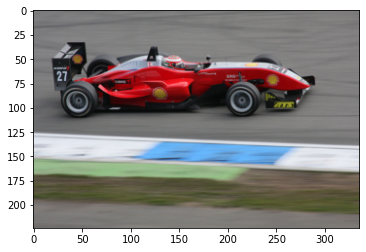

In [ ]:
display_tensor(source_image)

Pobranie modelu ResNet-50 pretrenowanego na zbiorze ImageNet.

**Uwaga:** Aby wykorzystać wytrenowaną sieć do wnioskowania, pamiętaj aby przełączyć ją w tryb ewaluacji `model().eval()`. Jeśli nie przełączysz modelu w tryb ewaluacji warstwy Dropout i BatchNorm nie będą działały poprawnie.
Dodatkowo wskazane jest wyłączenie liczenia gradientu, co przyśpieszy obliczenia.

W poniższym przykładzie zamrozimy cały model aby wyłączać obliczanie gradientu względem parametrów sieci. Ustawimy atrybut `requires_grad` wszystkich parametrów modelu na `False`.

In [ ]:
# Załaduj pretrenowany model ResNet50 i przełącz sieć w tryb ewaluacji
model = resnet50(pretrained=True)
model.eval()
model.to(device)    # Przenieś model na CUDA

# Zamroź model
# Wyłącz obliczanie gradientu dla parametrów modelu
for param in model.parameters():
  param.requires_grad = False


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Pomocnicze funkcje**:

`get_predicted_class(prediction_logits)` - zwraca id klasy o największym prawdopodobieństwie (jest to klasa o największej wartości logit'a)

`print_prediction_results(prediction_logits, true_class=None)` - wyświetla rezultaty predykcji: id i nazwę klasy o największym pradopodobieństwie i prawdopodobieństwo poprawnej klasy (jeśli podano parametr `true_class`)



In [ ]:
def get_predicted_class(prediction_logits):
  # Zwraca numer klas o największym prawdopodobieńswie
  # Jest to klasa o maksymalnej wartości logita
  _, predicted_class = prediction_logits.max(dim=0)
  return predicted_class.item()


def print_prediction_results(prediction_logits, true_class=None):
  # Wyświetla wyniki predykcji: predykowana klasa i jej prawdopodobieństwo
  # Jeśli podano true_class to wyświetla rownież jej prawdopodobieństwo
  assert prediction_logits.dim() == 1 or (prediction_logits.dim() == 2 and prediction_logits.shape[0] == 1)
  if prediction_logits.dim() == 2:
    # Usuń jednostkowy wymiar wsadu
    prediction_logits = prediction_logits.squeeze(0)

  predicted_class = get_predicted_class(prediction_logits)

  # Zamień logity (nieznormalizowane logarytmy prawdopodobieństwa) na rozkład prawdopodobieństwa klas
  softmax = nn.Softmax(dim=0)
  prediction_prob = softmax(prediction_logits)

  if true_class is None:
    s = 'Predykowana klasa: {} ({}) prawd.: {:0.4f}'
    print(s.format(predicted_class, imagenet_classes[predicted_class], prediction_prob[predicted_class].item()))
  else:
    s = 'Predykowana klasa: {} ({}) prawd. {:0.5f}    Prawdziwa klasa: {} ({}) prawd.: {:0.5f}'
    print(s.format(predicted_class,  imagenet_classes[predicted_class], prediction_prob[predicted_class].item(),
                   true_class, imagenet_classes[true_class], prediction_prob[true_class].item()))

Zbadajmy, jak zmienia się skuteczność klasyfikacji obrazu wejściowego przy zaburzeniu losowym szumem o coraz większym natężeniu. 


1.   Narysuj wykres pokazujący, jak zmienia się prawdopodobieństwo prawdziwej klasy obrazu zwracane przez sieć (dla wyścigówki jest to klasa 751 - racer) w zależności od natężenia szumu. 
2.   Sprawdź, dla jakiej wartości natężenia szumu klasyfikator zaczyna zwracać  błędne odpowiedzi - czyli kiedy jakaś inna, niepoprawna klasa ma większe prawdopodobieństwo niż klasa 751 (racer). Wyświetl taki zaszumiony obraz.

Dany obraz jest już znormalizowany i przekształcony do tensora `source_image`. Do klasyfikacji wykorzystaj załadowany wcześniej pretrenowany model klasyfikatora `model`.

Klasyfikator `model` zwraca nieznormalizowane logarytmy prawdopodobieństwa o wartościach od minus do plus nieskończoność (zwane logit'ami). Aby zamienić je na warstości prawdopodobieństwa, możesz użyć funkcji `torch.nn.functional.softmax`. Dla jednoelementowego wsadu $(N=1, C=3, H, W)$, rozmiar wyjściowego tensora to $(1, 1000)$, gdzie 1 to rozmiar wsadu, a 1000 to liczba klas. 

Jako model szumu wykorzystamy addytywny szum o rozkładzie Gaussa o średniej wartości 0 i zadanej wariancji $\sigma$ (*Gaussian noise*). 

source_image shape: torch.Size([1, 3, 224, 336])
Predykowana klasa: 751 (racer) prawd.: 0.7289


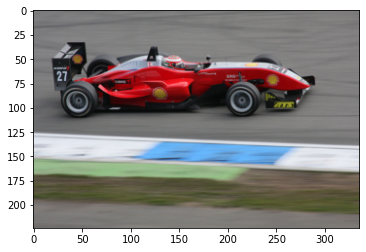

In [ ]:
# Wyświetl niezaszumiony obraz
display_tensor(source_image)
print('source_image shape: {}'.format(source_image.shape))

prediction_logits = model(source_image)
print_prediction_results(prediction_logits, true_class=None)

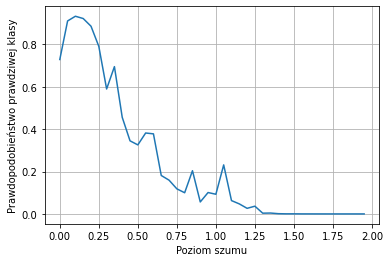

Pierwszy błędnie sklasyfikowany obraz. Sklasyfikowano jako: 817 (sports_car). Poziom szumu: 0.45.


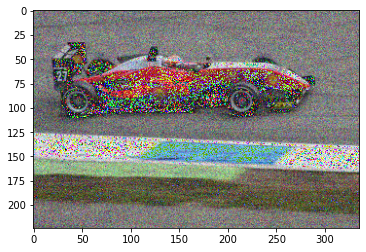

In [ ]:
# Wykorzystamy addytywny szum o rozkładzenie Gaussa
noise_levels = np.arange(0., 2., 0.05)

true_class_prob_l = []

mis_image = None
mis_noise_level = None
mis_predicted_class = None

for level in noise_levels:
  # Wygeneruj losowy szum o natężeniu level 
  noise = torch.randn(source_image.shape) * level
  noise = noise.to(device)

  # Utwórz zaszumiony obraz przez dodanie szumu do tensora z obrazem (source_image)
  noisy_image = source_image + noise

  # Wyznacz wektor predykcji dla zaszumionego obrazu korzystając z klasyfikatora (model)
  prediction_logits = model(noisy_image)
  
  prediction_logits = prediction_logits.squeeze(0)
  prediction_prob = torch.nn.functional.softmax(prediction_logits, dim=0)

  # Wyznacz i zapamiętaj prawdopodobieństwo poprawnej klasy (true_class = 751 - racer)
  true_class_prob_l.append(prediction_prob[true_class].item()) 

  # Wyznacz id najbardziej prawdopodobnej klasy; jeśli jest różne od prawdziwej klasy true_class,
  # to zapamiętaj zaszumiony obraz i natężenie szumu dla którego wystąpiła pierwsza błędna klasyfikacja
  predicted_class_pp, predicted_class = prediction_logits.max(dim=0)
  if predicted_class != true_class:
    # Błędna predykcja - inna klasa ma większe prawdopodobieństwo
    if mis_image is None:
      mis_image = noisy_image
      mis_noise_level = level
      mis_predicted_class = predicted_class.item()
  
# Wyświetl wykres zależności prawdopodobieństwa prawdziwej klasy od natężenia szumu
# Możesz wykorzystać funkcje plot z modułu matplotlib.pyplot zaimportowaną jako plt
plt.plot(noise_levels, true_class_prob_l)
plt.xlabel("Poziom szumu")
plt.ylabel("Prawdopodobieństwo prawdziwej klasy")
plt.grid()
plt.show()

# Wyświetl pierwszy błędnie sklasyfikowany obraz, jego predykowaną klasę i natężenie szumu dla którego nastąpiła ta błędna predykcja
if mis_image is not None:
  print(f'Pierwszy błędnie sklasyfikowany obraz. Sklasyfikowano jako: {mis_predicted_class} ({imagenet_classes[mis_predicted_class]}). Poziom szumu: {mis_noise_level}.')
  display_tensor(mis_image)


Przy zaburzaniu obrazu losowym szumem można zaobserować zaskakujące zjawisko. Prawdopodobieństwo poprawnego sklasyfikowania obrazu początkowo (w zakresie mniej więcej od 0 do 0.1 dla szumu Gaussa) zaczyna wzrastać wraz ze wzrostem wielkości zaburzeń. 
Poziom losowych zaburzeń, dla których klasyfikator zaczyna zwracać błędne odpowiedzi jest dość wysoki. Zaburzenia są wyraźnie widoczne gołym okiem i zaburzony obraz znacznie różni się od oryginału.

## 3. Generowanie przykładów zatrutych

### Atak niemierzony (untargeted attack)

Naszym celem jest znalezienia takiego wektora perturbacji $\delta$ aby **zmaksymalizować** błąd klasyfikacji obrazu wejściowego. Algorytm postępowania jest bardzo podobny jak podczas 'zwykłego' uczenia sieci neuronowej, z następującymi różnicami:
*   Podczas 'zwykłego' uczenia sieci neuronowej **optymalizujemy parametry** (wagi 
sieci) - nie zmieniając danych treningowych - aby **zminimalizować** wartość funkcji straty dla obrazów ze zbioru treningowego. 
*   Aby wygenerować przykłady zatrute, musimi postąpić niejako odwrotnie. **Modyfikujemy dane** - zachowując niezmienione wagi sieci - aby **zmaksymalizować** wartość funkcji straty. Szukamy zatem takiego wektora perturbacji $\delta$ który maksymalizuje wartość funkcji straty $\mathcal{l}$:

$$ \max_{\|\delta\| \leq \epsilon} \mathcal{l}(h_{\Theta}(x+\delta),y) \ ,$$
gdzie $h_{\Theta}$ jest klasyfikatorem - siecią neuronową z parametrami $\Theta$, $x$ jest wektorem danych wejściowych a $y$ identyfikatorem jego klasy. $\epsilon$ jest wartością skalarną określającą maksymalną wartość perturbacji obrazu źródłowego.

Aby zmaksymalizować wartość funkcji straty $\mathcal{l}$ zmieniamy wektor perturbacji $\delta$ zgodnie z kierunkiem jego gradientu (czyli zgodnie z kierunkiem największego wzrostu wartości funkcji straty). **Ogólny algorytm generowania przykładów zatrutych** jest następujący:

0.   Ustal początkową wartość wektora perturbacji na zero $\delta:=\mathbf{0}$.
1.   Wyznacz gradient funkcji straty $\mathcal{l}$ względem wektora perturbajcji $\delta$
$$g := \nabla_{\delta} \mathcal{l}(h_{\Theta} (x+\delta),y) $$
korzystając z algorymtu propagacji wstecznej.
2.   Zmień wartość wektora perturbacji $\delta$ w kierunku zgodnym z kierunkiem gradientu (*metoda największego wzrostu*):
$$
\delta := \delta + \alpha g \ ,
$$ gdzie $\alpha$ jest wartością kroku.
3.   Ogranicz wartości współrzędnych wektora perturbacji $\delta$ aby leżał wewnątrz hiperkuli o promieniu $\epsilon$, czyli aby $\| \delta \| \leq \epsilon$ (chcemy aby wygenerowane zaburzenie nie było zbyt duże). Jeśli wektor perturbacji $\delta$ wykracza poza to ograniczenie, rzutuj go na powierzchnię hiperkuli $\| \delta \| = \epsilon$.
4.   (opcjonalnie) Powtarzaj kroki 1-4

Poniżej podamy dwa konkretne algorytmy generowania przykładów zatrutych:


*   Metoda FGSM (Fast Gradient Sign Method) - metoda nie-iteracyjna oparta o normę $L_{inf}$.
*   Metoda PGD (Projected Gradient Descent) - metoda iteracyjna oparta o normę $L_{inf}$.



#### Atak Projected Gradient Descent (PGM)

Metoda PGM jest iteracyjną metodą ataku z normą $L_{inf}$.
Ograniczenie wielkości wektora perturbacji $\delta$ jest identyczne jak w metodzie FGSM:  $\| \delta \|_{\inf} \leq \epsilon$. Czyli dla każdej współrzędnej wektora $\delta$ mamy: $\forall_i | \delta_i | \leq \epsilon $.
Metoda składa się z następujących kroków:


0.   Ustal początkową wartość wektora perturbacji na zero $\delta:=\mathbf{0}$.
1.   Wyznacz gradient funkcji straty $\mathcal{l}$ względem wektora perturbajcji $\delta$
$$g := \nabla_{\delta} \mathcal{l}(h_{\Theta} (x+\delta),y) $$
korzystając z algorymtu propagacji wstecznej.
2.   Zmień wartość wektora perturbacji $\delta$ w kierunku zgodnym z kierunkiem gradientu (*metoda największego wzrostu*):
$$
\delta := \delta + \alpha g \ ,
$$ gdzie $\alpha$ jest wartością kroku.
3.   Ogranicz wartość każdej ze współrzędnych $\delta_i$ wektora perturbacji do przedziału $\langle-\epsilon..\epsilon\rangle$. 
$$
\delta_i =
\left\{
	\begin{array}{ll}
		\delta_i  & \mbox{if } -\epsilon \leq \delta_i \leq \epsilon \\
		-\epsilon & \mbox{if } \delta_i < -\epsilon \\
		\epsilon & \mbox{if } \delta_i > \epsilon
	\end{array}
\right.
$$
4.   Powtarzaj kroki 1-4



Naszym celem jest wygenerowanie takiego wektora perturbacji $\delta$ aby **zmaksymalizować** błąd klasyfikacji - co jest równoważne **maksymalizacji wartości funkcji straty** dla zatrutego obrazu.
Atak zaimplementujemy korzystając z optymalizatora opartego o metodę spadku wzdłuż gradientu (SGD) dostępnego w Pytorch. Ponieważ optymalizatory w PyTorchu z założenia minimalizują wartość funckji, zastosujemy prostą sztuczkę. Będziemy minimalizowali funkcję przeciwną do funkcji straty entropii krzyżowej - co jest równoważne z maksymalizacją funkcji straty. Czyli funkcję straty zapiszemy następująco:
`loss = -nn.CrossEntropyLoss()(...)`.

Optymalizacji będzie podlegał tylko tensor perturbacji $\delta$. Nie chcemy zmieniać wag sieci ani zawartości oryginalnego obrazu. Dlatego do optymalizatora przekazujemy tylko parametr $\delta$: `optim.SGD([delta], lr=1e-1)`


### Atak mierzony (targeted attack)

Sprawdźmy, czy możemy tak zmodyfikować obraz, aby sieć klasyfikowała go jako zupełnie inną klasę, np. słonia!

W tym przypadku chcemy znaleźć taką wartość tensora perturbacji $\delta$, aby **zmaksymalizować wartość funkcji straty dla prawdziwej klasy** obrazu wejściowego, a **zminimalizować ją dla klasy docelowej**. Dlatego funkcja straty którą minimalizujemy iteracyjną metodą największego spadku ma postać:


```
loss = (-cross_entropy_loss(pred_logits, torch.cuda.LongTensor([true_class])) + 
            cross_entropy_loss(pred_logits, torch.cuda.LongTensor([target_class])))
```



$$
\max_{\|\delta\| \leq \epsilon} 
\left(
\mathcal{l}(h_{\Theta} (x+\delta),y) - \mathcal{l}(h_{\Theta} (x+\delta),y_{\mathrm{target}})
\right)
$$

Pomocnicze funkcje do przeprowadzenia **ataku mierzonego**.

In [ ]:
def targeted_attack(model, source_image, true_class, target_class, n_iter=200, 
                    epsilon=2./255.):
  # model: wytrenowany model sieci
  # source_image: obraz źródłowy
  # true_class: prawdziwa klasa obrazu źródłowego
  # target_class: docelowa klasa zaburzonego obrazu
  # n_iter: liczba iteracji procedury optymalizacyjnej
  # epsilon: maksymalna zmiana wartośi piksela
  # funkcja zwraca tensor delta: zaburzenie
  print('Poprawna klasa: {} ({})'.format(true_class, imagenet_classes[true_class]))
  print('Klasa docelowa: {} ({})'.format(target_class, imagenet_classes[target_class]))

  # requires_grad oznacza, że gradient będzie wyznaczany względem elementów tensora delta
  delta = torch.zeros_like(source_image, requires_grad=True)
  
  # Do optymalizatora przekazujemy tylko tensor delta
  # oznacza to, że w procesie propagracji wstecznej będą optymalizowane tylko
  # elementy tensora delta, a nie będą zmieniane wagi sieci ani oryginalny obraz
  opt = optim.SGD([delta], lr=1e-2)
  
  cross_entropy_loss = nn.CrossEntropyLoss()

  for t in range(n_iter):
    pred_logits = model(source_image + delta)
    loss = (-cross_entropy_loss(pred_logits, torch.LongTensor([true_class], device=device)) + 
            cross_entropy_loss(pred_logits, torch.LongTensor([target_class], device=device)))
    if t % 10 == 0:
      print('Krok: {} Loss: {}'.format(t, loss.item()))
      print_prediction_results(pred_logits, true_class=true_class)
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)  

  return delta

Uruchom atak celowany. Zmieniamy wyścigówkę w słonia (klasa 385 słoń indyjski).
Jeśli chciałbyś poeksperymentować samodzielnie, to identyfikatory klas ImageNet sprawdzisz tutaj: [link](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
). 

In [ ]:
target_class = 385 # Indian elephant
epsilon = 3./255.

delta = targeted_attack(model, source_image, true_class, target_class, 
                        n_iter=400, epsilon=epsilon)

Poprawna klasa: 751 (racer)
Klasa docelowa: 385 (Indian_elephant)
Krok: 0 Loss: 16.09195899963379
Predykowana klasa: 751 (racer) prawd. 0.72888    Prawdziwa klasa: 751 (racer) prawd.: 0.72888
Krok: 10 Loss: 11.089193344116211
Predykowana klasa: 751 (racer) prawd. 0.48106    Prawdziwa klasa: 751 (racer) prawd.: 0.48106
Krok: 20 Loss: 8.360984802246094
Predykowana klasa: 817 (sports_car) prawd. 0.47470    Prawdziwa klasa: 751 (racer) prawd.: 0.30468
Krok: 30 Loss: 6.2286529541015625
Predykowana klasa: 817 (sports_car) prawd. 0.37115    Prawdziwa klasa: 751 (racer) prawd.: 0.16556
Krok: 40 Loss: 4.295071125030518
Predykowana klasa: 814 (speedboat) prawd. 0.26748    Prawdziwa klasa: 751 (racer) prawd.: 0.06699
Krok: 50 Loss: 2.570516586303711
Predykowana klasa: 814 (speedboat) prawd. 0.32401    Prawdziwa klasa: 751 (racer) prawd.: 0.02402
Krok: 60 Loss: 1.2204270362854004
Predykowana klasa: 814 (speedboat) prawd. 0.33161    Prawdziwa klasa: 751 (racer) prawd.: 0.01063
Krok: 70 Loss: 0.1078

Z jakim prawdopodobieństwem model rozpoznaje zatruty obraz jako wyścigówkę, a z jakim jako słonia?

Wyświetl obraz oryginalny i zatruty. Znajdź słonia na obrazie zatrutym.

Obraz źródłowy:
Predykowana klasa: 751 (racer) prawd.: 0.7289

Obraz zatruty:
Predykowana klasa: 385 (Indian_elephant) prawd. 0.42459    Prawdziwa klasa: 751 (racer) prawd.: 0.00001


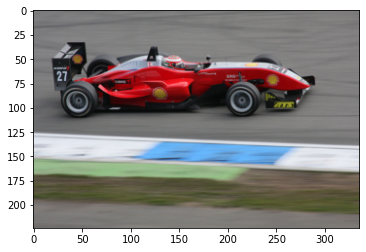

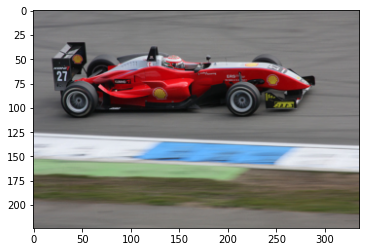

In [ ]:
# Wyświetl obraz oryginalny
display_tensor(source_image) 
plt.figure()

# Wyświetl obraz zaburzony
display_tensor(source_image + delta)

print('Obraz źródłowy:')
pred_logits = model(source_image)
print_prediction_results(pred_logits)
print('')
print('Obraz zatruty:')
pred_logits = model(source_image + delta)
print_prediction_results(pred_logits, true_class=true_class)

Oryginalny obraz i zatruty obraz wyglądają identycznie. Wyświetlmy różnice między obrazem zatrutym a obrazem źródłowym: `source_image + delta - source_image = delta`. 

delta zawiera wartości pomiędzy: -0.0117647061 a 0.0117647061


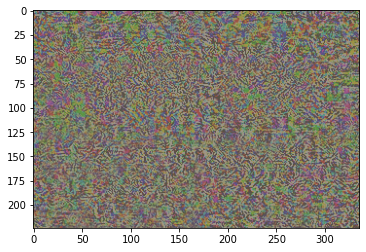

In [ ]:
print('delta zawiera wartości pomiędzy: {:0.10f} a {:0.10f}'.format(torch.min(delta.detach()), torch.max(delta.detach())))

# Do celów wizualizacji pomnóż wartości zaburzeń przez 50
display_tensor(50*delta)

Zmiany wartości pikseli między jednym a drugim obrazem są bardzo małe i niedostrzegalne gołym okiem. Zakłócenia `delta` mają wartości bezwzględne poniżej 0.012. A model jest przekonany, że pierwszy obraz to wyścigówka (prawdopodobieństwo 73%) a drugi obraz to na pewno nie jest wyścigówka (prawd. 0%) tylko słoń (prawd. 45%).

Tekstura nawierzchni drogi trochę przypomina skórę słonia, może dzięki temu było możliwe wprowdzenie w błąd klasyfikatora? Spróbujmy zatem teraz czegoś trudniejszego - przekształćmy wyścigowkę (klasa 751) w hot doga (klasa 934).

In [ ]:
target_class = 934   # hotdog

#Zwiększ maksymalny poziom perturbacji do 5/255
epsilon = 5./255.

delta = targeted_attack(model, source_image, true_class, target_class, 
                        n_iter=400, epsilon=epsilon)


Poprawna klasa: 751 (racer)
Klasa docelowa: 934 (hotdog)
Krok: 0 Loss: 16.572654724121094
Predykowana klasa: 751 (racer) prawd. 0.72888    Prawdziwa klasa: 751 (racer) prawd.: 0.72888
Krok: 10 Loss: 11.239419937133789
Predykowana klasa: 751 (racer) prawd. 0.47629    Prawdziwa klasa: 751 (racer) prawd.: 0.47629
Krok: 20 Loss: 8.323004722595215
Predykowana klasa: 817 (sports_car) prawd. 0.45297    Prawdziwa klasa: 751 (racer) prawd.: 0.29546
Krok: 30 Loss: 6.261564254760742
Predykowana klasa: 817 (sports_car) prawd. 0.36487    Prawdziwa klasa: 751 (racer) prawd.: 0.16745
Krok: 40 Loss: 4.679254055023193
Predykowana klasa: 817 (sports_car) prawd. 0.25499    Prawdziwa klasa: 751 (racer) prawd.: 0.09065
Krok: 50 Loss: 3.4314022064208984
Predykowana klasa: 817 (sports_car) prawd. 0.16889    Prawdziwa klasa: 751 (racer) prawd.: 0.04841
Krok: 60 Loss: 2.3457980155944824
Predykowana klasa: 814 (speedboat) prawd. 0.15601    Prawdziwa klasa: 751 (racer) prawd.: 0.02657
Krok: 70 Loss: 1.4000935554

Wyświetl obraz oryginalny `source_image` i zatruty `source_image + delta`.

Obraz źródłowy (górny):
Predykowana klasa: 751 (racer) prawd.: 0.7289

Obraz zatruty (dolny):
Predykowana klasa: 934 (hotdog) prawd. 0.97279    Prawdziwa klasa: 751 (racer) prawd.: 0.00000


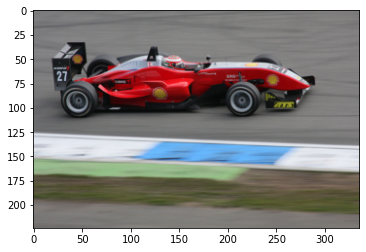

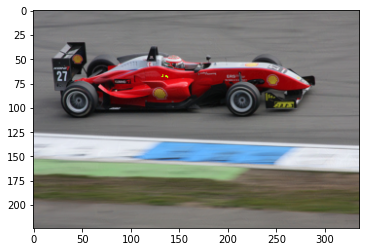

In [ ]:
# Wyświetl obraz oryginalny
display_tensor(source_image) 
plt.figure()

# Wyświetl obraz zaburzony
display_tensor(source_image + delta)

print('Obraz źródłowy (górny):')
pred_logits = model(source_image)
print_prediction_results(pred_logits)
print('')
print('Obraz zatruty (dolny):')
pred_logits = model(source_image + delta)
print_prediction_results(pred_logits, true_class=true_class)

Wyświetl obraz z zaburzeniami wzmocnionymi 10 krotnie.

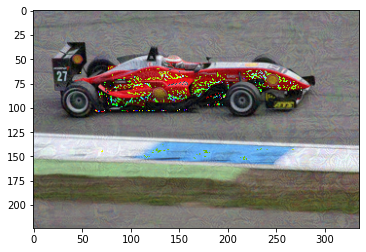

In [ ]:
# Wyświetl obraz zaburzony
display_tensor(source_image + 10*delta)

Jako końcowy eksperyment poluzujemy ograniczenia: zwiększymy wartość parametru `epsilon` do $50/255$ i zwiększmy liczbę iteracji do 1000. Czy udało się wygenerować obraz prawdziwego hot doga? Z jakim pradopodobieństwem pretrenowana sieć klasyfikuje tak zatruty obraz jako hot doga? Czy obraz zatruty wizualnie różni się od oryginalnego?


In [ ]:
target_class = 934   # hotdog

epsilon = 50./255.

delta = targeted_attack(model, source_image, true_class, target_class, 
                        n_iter=1000, epsilon=epsilon)


Poprawna klasa: 751 (racer)
Klasa docelowa: 934 (hotdog)
Krok: 0 Loss: 16.572654724121094
Predykowana klasa: 751 (racer) prawd. 0.72888    Prawdziwa klasa: 751 (racer) prawd.: 0.72888
Krok: 10 Loss: 11.239415168762207
Predykowana klasa: 751 (racer) prawd. 0.47629    Prawdziwa klasa: 751 (racer) prawd.: 0.47629
Krok: 20 Loss: 8.321756362915039
Predykowana klasa: 817 (sports_car) prawd. 0.45289    Prawdziwa klasa: 751 (racer) prawd.: 0.29545
Krok: 30 Loss: 6.2536725997924805
Predykowana klasa: 817 (sports_car) prawd. 0.36405    Prawdziwa klasa: 751 (racer) prawd.: 0.16743
Krok: 40 Loss: 4.6504669189453125
Predykowana klasa: 817 (sports_car) prawd. 0.25332    Prawdziwa klasa: 751 (racer) prawd.: 0.08966
Krok: 50 Loss: 3.377804756164551
Predykowana klasa: 817 (sports_car) prawd. 0.16642    Prawdziwa klasa: 751 (racer) prawd.: 0.04713
Krok: 60 Loss: 2.2291951179504395
Predykowana klasa: 814 (speedboat) prawd. 0.15359    Prawdziwa klasa: 751 (racer) prawd.: 0.02472
Krok: 70 Loss: 1.206286907

Wyświetl obraz oryginalny `source_image` i zatruty `source_image + delta`.

Predykowana klasa: 934 (hotdog) prawd. 1.00000    Prawdziwa klasa: 751 (racer) prawd.: 0.00000


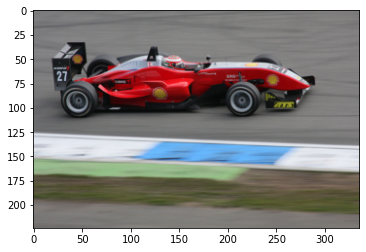

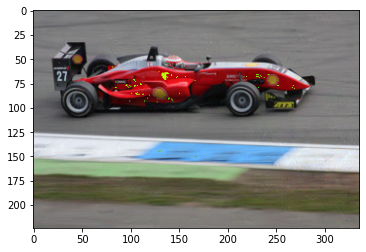

In [ ]:
# Wyświetl obraz oryginalny (góra)
display_tensor(source_image) 
plt.figure()

# Wyświetl obraz zaburzony (dół)
display_tensor(source_image + delta)

pred_logits = model(source_image + delta)
print_prediction_results(pred_logits, true_class=true_class)

delta zawiera wartości pomiędzy: -0.1960784346 a 0.1960784346


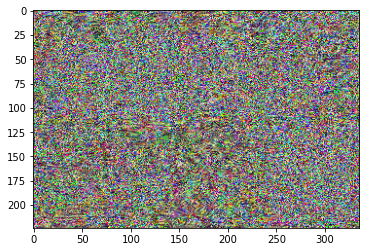

In [ ]:
print('delta zawiera wartości pomiędzy: {:0.10f} a {:0.10f}'.format(torch.min(delta.detach()), torch.max(delta.detach())))
display_tensor(delta*50)